# Quant Research Project 1: Mean Reversion Strategy

This notebook investigates a simple mean-reversion strategy using daily price data.

## Objectives
- Retrieve and clean equity data from Yahoo Finance
- Explore basic descriptive statistics
- Construct a mean-reversion signal using rolling z-scores
- Backtest a naive long/short trading rule
- Include parameter tuning, transaction costs, and visual analysis

In [57]:
# --- Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

## 1. Data Retrieval

In [ ]:
# Load local data
data = pd.read_csv('../data/spy_data.csv', index_col=0, parse_dates=True)

data.head()

## 2. Exploratory Data Analysis

             Close         High          Low         Open        Volume
count  2516.000000  2516.000000  2516.000000  2516.000000  2.516000e+03
mean    311.230267   312.868718   309.348818   311.185093  8.743599e+07
std     114.825322   115.381567   114.184983   114.821368  4.490947e+07
min     155.438858   156.492916   153.333352   154.996832  2.027000e+07
25%     212.799789   213.451358   212.051414   212.863359  5.893120e+07
50%     274.021561   274.770479   273.009664   274.044263  7.659475e+07
75%     400.511276   402.759362   397.835414   400.440676  1.022602e+08
max     600.509338   601.754214   599.728849   600.390725  5.072443e+08


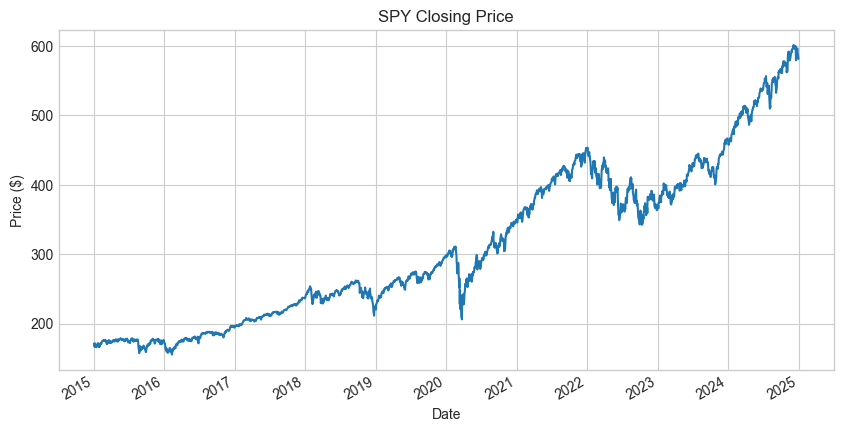

In [67]:
print(data.describe())
data['Close'].plot(title=f'{ticker} Closing Price', figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.show()

## 3. Signal Construction & Backtest

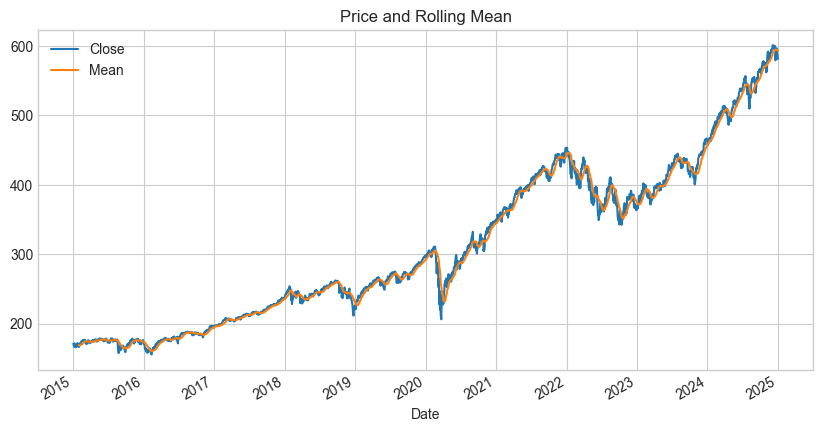

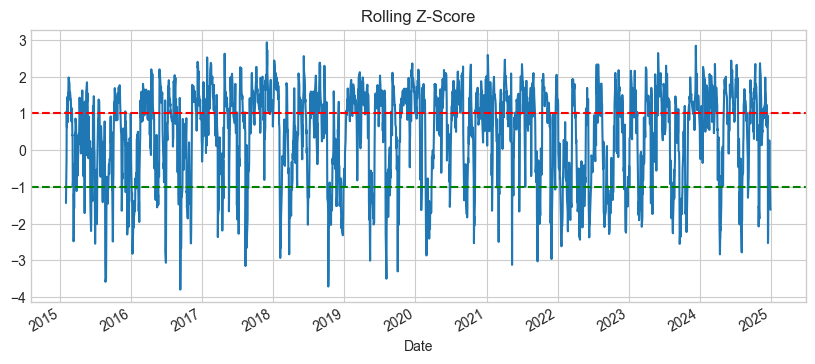

In [68]:
window = 20
threshold = 1
data['Mean'] = data['Close'].rolling(window=window).mean()
data['Std'] = data['Close'].rolling(window=window).std()
data['Z_Score'] = (data['Close'] - data['Mean']) / data['Std']

# Plot Price and Rolling Mean
data[['Close','Mean']].plot(title='Price and Rolling Mean', figsize=(10,5))
plt.show()

# Plot Z-Score
data['Z_Score'].plot(title='Rolling Z-Score', figsize=(10,4))
plt.axhline(threshold, color='red', linestyle='--')
plt.axhline(-threshold, color='green', linestyle='--')
plt.show()

# Signals
data['Signal'] = 0
data.loc[data['Z_Score'] < -threshold, 'Signal'] = 1
data.loc[data['Z_Score'] > threshold, 'Signal'] = -1
data['Signal'] = data['Signal'].shift(1)

# Returns
data['Return'] = data['Close'].pct_change()
data['Strategy_Return'] = data['Signal'] * data['Return']

## 4. Strategy Performance

CAGR: -1.39%
Sharpe Ratio: -0.03


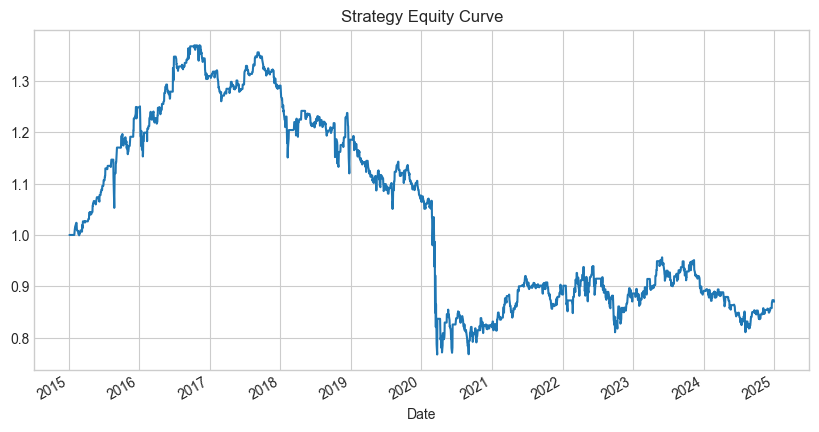

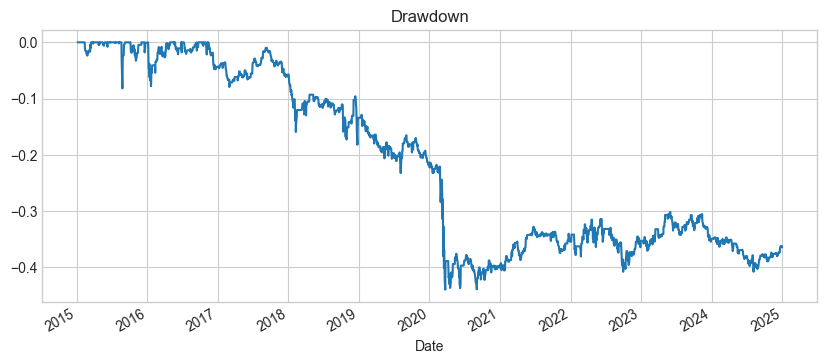

In [69]:
# Baseline Sharpe & CAGR
cagr = (1 + data['Strategy_Return']).prod() ** (252/len(data)) - 1
sharpe = np.sqrt(252) * data['Strategy_Return'].mean() / data['Strategy_Return'].std()
print(f'CAGR: {cagr:.2%}')
print(f'Sharpe Ratio: {sharpe:.2f}')

# Equity curve
data['Cumulative_Strategy'] = (1 + data['Strategy_Return']).cumprod()
data['Cumulative_Strategy'].plot(title='Strategy Equity Curve', figsize=(10,5))
plt.show()

# Drawdown
roll_max = data['Cumulative_Strategy'].cummax()
drawdown = (data['Cumulative_Strategy'] - roll_max)/roll_max
drawdown.plot(title='Drawdown', figsize=(10,4))
plt.show()

## 5. Parameter Tuning

In [70]:
for w in [10, 20, 30, 40, 50]:
    for t in [0.25, 0.5, 0.75, 1.0, 1.25, 1.5]:
        data['Mean'] = data['Close'].rolling(window=w).mean()
        data['Std'] = data['Close'].rolling(window=w).std()
        data['Z_Score'] = (data['Close'] - data['Mean']) / data['Std']
        data['Signal'] = 0
        data.loc[data['Z_Score'] < -t, 'Signal'] = 1
        data.loc[data['Z_Score'] > t, 'Signal'] = -1
        data['Signal'] = data['Signal'].shift(1)
        data['Strategy_Return'] = data['Signal'] * data['Return']
        sharpe_val = np.sqrt(252) * data['Strategy_Return'].mean() / data['Strategy_Return'].std()
        print(f'Window={w}, Threshold={t}, Sharpe={sharpe_val:.2f}')

Window=10, Threshold=0.25, Sharpe=0.02
Window=10, Threshold=0.5, Sharpe=0.07
Window=10, Threshold=0.75, Sharpe=0.04
Window=10, Threshold=1.0, Sharpe=0.17
Window=10, Threshold=1.25, Sharpe=0.22
Window=10, Threshold=1.5, Sharpe=0.23
Window=20, Threshold=0.25, Sharpe=-0.14
Window=20, Threshold=0.5, Sharpe=-0.13
Window=20, Threshold=0.75, Sharpe=-0.17
Window=20, Threshold=1.0, Sharpe=-0.03
Window=20, Threshold=1.25, Sharpe=0.02
Window=20, Threshold=1.5, Sharpe=0.34
Window=30, Threshold=0.25, Sharpe=-0.13
Window=30, Threshold=0.5, Sharpe=-0.14
Window=30, Threshold=0.75, Sharpe=-0.26
Window=30, Threshold=1.0, Sharpe=-0.04
Window=30, Threshold=1.25, Sharpe=0.19
Window=30, Threshold=1.5, Sharpe=0.06
Window=40, Threshold=0.25, Sharpe=-0.00
Window=40, Threshold=0.5, Sharpe=-0.04
Window=40, Threshold=0.75, Sharpe=0.07
Window=40, Threshold=1.0, Sharpe=-0.03
Window=40, Threshold=1.25, Sharpe=0.02
Window=40, Threshold=1.5, Sharpe=0.02
Window=50, Threshold=0.25, Sharpe=-0.06
Window=50, Threshold=0.5,

## 6. Transaction Costs (Optional)

In [71]:
cost = 0.001  # 0.1% per trade
data['Strategy_Return_TC'] = data['Strategy_Return'] - cost * data['Signal'].diff().abs()
cagr_tc = (1 + data['Strategy_Return_TC']).prod() ** (252/len(data)) - 1
sharpe_tc = np.sqrt(252) * data['Strategy_Return_TC'].mean() / data['Strategy_Return_TC'].std()
print(f'CAGR with TC: {cagr_tc:.2%}, Sharpe with TC: {sharpe_tc:.2f}')

CAGR with TC: -3.47%, Sharpe with TC: -0.24


## 7. Next Steps / Portfolio Ready Enhancements
- Tune rolling window and z-score thresholds
- Apply to multiple tickers or sectors
- Add momentum or moving average crossover signals
- Include risk-adjusted position sizing
- Create README.md and summary plots for GitHub
- Explore Monte Carlo simulation for Sharpe robustness

## 8. Multi Ticker

<Axes: title={'center': 'Closing Prices'}, xlabel='Date'>

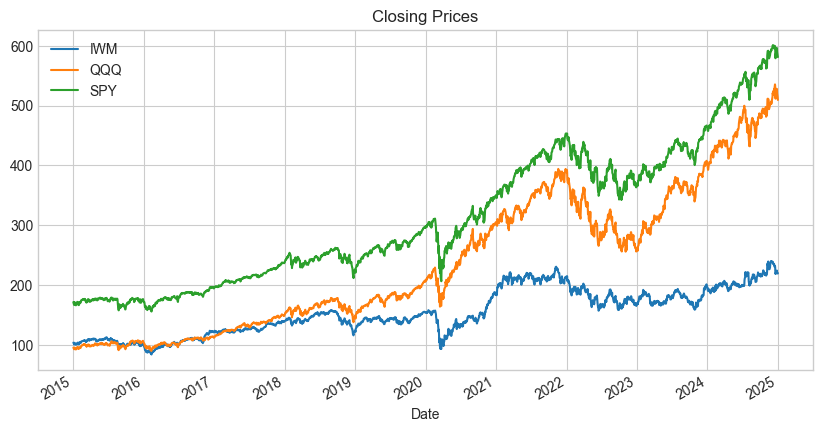

In [74]:
# Load local data
data = pd.read_csv('../data/spy_qqq_iwm_close.csv', index_col=0, parse_dates=True)

data.plot(title='Closing Prices', figsize=(10,5))


<Axes: title={'center': 'Portfolio Total Price (Naive Sum)'}, xlabel='Date'>

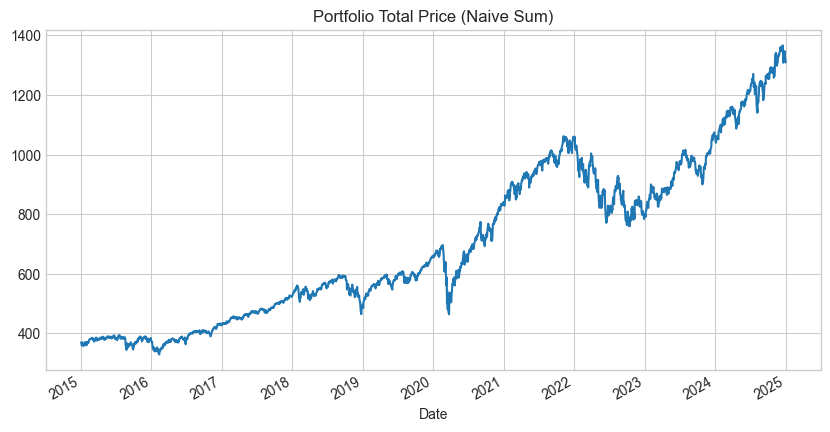

In [54]:
# Sum closing prices across tickers
portfolio_price = data.sum(axis=1)

# Plot
portfolio_price.plot(title='Portfolio Total Price (Naive Sum)', figsize=(10,5))


CAGR: -2.30%, Sharpe: -0.10


C:\Users\jarvi\AppData\Local\Temp\ipykernel_11332\1891493915.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  cagr = equity[-1]**(1/years) - 1


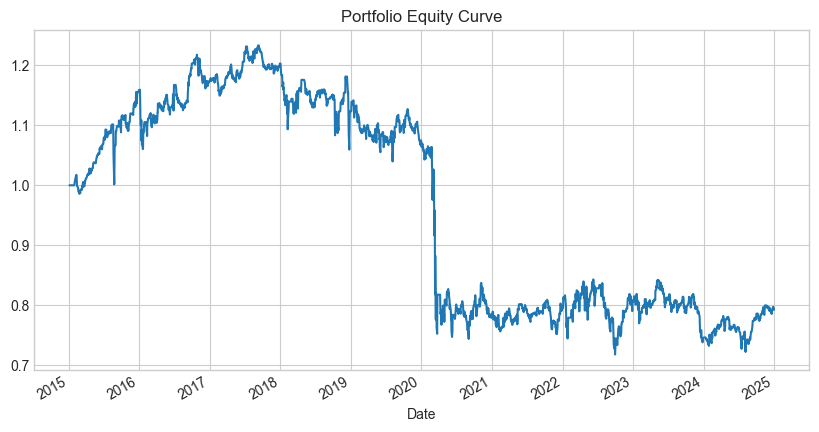

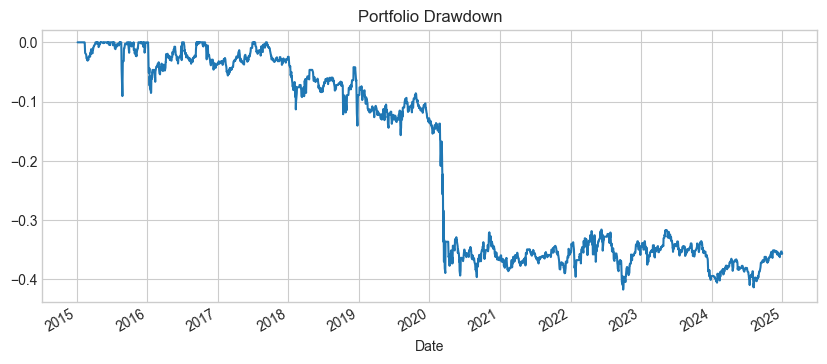

In [75]:
# Compute returns
returns = data.pct_change()

# Rolling z-scores
window = 20
z_scores = (data - data.rolling(window).mean()) / data.rolling(window).std()

# Signals
signals = pd.DataFrame(0, index=data.index, columns=tickers)
signals[z_scores < -1] = 1
signals[z_scores > 1] = -1
signals = signals.shift(1)  # avoid lookahead

# Strategy returns
strategy_returns = signals * returns

# Portfolio return (equal-weighted)
portfolio_return = strategy_returns.mean(axis=1)

# Cumulative equity
equity = (1 + portfolio_return).cumprod()

# CAGR
years = (equity.index[-1] - equity.index[0]).days / 365
cagr = equity[-1]**(1/years) - 1

# Sharpe
sharpe = np.sqrt(252) * portfolio_return.mean() / portfolio_return.std()

print(f"CAGR: {cagr:.2%}, Sharpe: {sharpe:.2f}")

# Plot
equity.plot(title='Portfolio Equity Curve', figsize=(10,5))
plt.show()

roll_max = equity.cummax()
drawdown = (equity - roll_max)/roll_max
drawdown.plot(title='Portfolio Drawdown', figsize=(10,4))
plt.show()
